<a href="https://colab.research.google.com/github/ZahraAlharz/Oxford-AI-Summer-School/blob/main/VAE_HW4_CV_Oxford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement  Variational Autoencoder for Image Attribute Manipulation with CelebA
The objective of this homework is to implement a Variational Autoencoder (VAE) in PyTorch and use it for image attribute manipulation on the CelebA dataset.

For example: Change hair color or add glasses

##Dataset:
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

*   10,177 number of identities,
*   202,599 number of face images, and
*   5 landmark locations, 40 binary attributes annotations per image.



##Tasks:

1. Implement a conditional VAE (CVAE) that can manipulate image attributes.
2. Train the VAE on the CelebA dataset. Hint: VAE will be conditional VAE
3. Manipulate specific attributes of the images.
4. Evaluate and visualize the results.

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms, utils
from torchvision.datasets import CelebA
from torch import optim

from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CelebA dataset
#dataset = CelebA(root='./data', split='train', download=True, transform=transform)
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


# Download the Datset on the Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change directory to CelebA dataset location
%cd /content/drive/My\Drive/CelebA

Mounted at /content/drive
/content/drive/MyDrive/CelebA


## Unzip the Images file

In [ ]:
#!unzip img_align_celeba.zip -d img_align_celeba

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/img_align_celeba/197600.jpg  
 extracting: img_align_celeba/img_align_celeba/197601.jpg  
 extracting: img_align_celeba/img_align_celeba/197602.jpg  
 extracting: img_align_celeba/img_align_celeba/197603.jpg  
 extracting: img_align_celeba/img_align_celeba/197604.jpg  
 extracting: img_align_celeba/img_align_celeba/197605.jpg  
 extracting: img_align_celeba/img_align_celeba/197606.jpg  
 extracting: img_align_celeba/img_align_celeba/197607.jpg  
 extracting: img_align_celeba/img_align_celeba/197608.jpg  
 extracting: img_align_celeba/img_align_celeba/197609.jpg  
 extracting: img_align_celeba/img_align_celeba/197610.jpg  
 extracting: img_align_celeba/img_align_celeba/197611.jpg  
 extracting: img_align_celeba/img_align_celeba/197612.jpg  
 extracting: img_align_celeba/img_align_celeba/197613.jpg  
 extracting: img_align_celeba/img_align_celeba/197614.jpg  
 extracting: img_align_celeba/img_align_celeba/19

# Create Custom Datset Class

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.attrs = self.load_attributes(attr_path)
        self.imgs = sorted(os.listdir(self.img_dir))  # Ensure sorted to match the attribute file order

    def load_attributes(self, attr_path):
        with open(attr_path, 'r') as f:
            lines = f.readlines()
            attr_names = lines[1].split()
            attrs = {}
            for line in lines[2:]:
                parts = line.split()
                img_name = parts[0]
                # Convert -1 to 0 in the attributes
                attr_values = [0 if int(x) == -1 else 1 for x in parts[1:]]
                attrs[img_name] = torch.tensor(attr_values, dtype=torch.float32)
        return attrs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        attributes = self.attrs[img_name]
        return image, attributes

# Create the Dataset and the Dataloader

In [ ]:
# Dataset and DataLoader
dataset = CelebADataset(img_dir='img_align_celeba/img_align_celeba', attr_path='list_attr_celeba.txt', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers= 4)

In [ ]:
# Verify the data loading
dataiter = iter(dataloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 64, 64])
torch.Size([64, 40])


# Visualizing some sample images

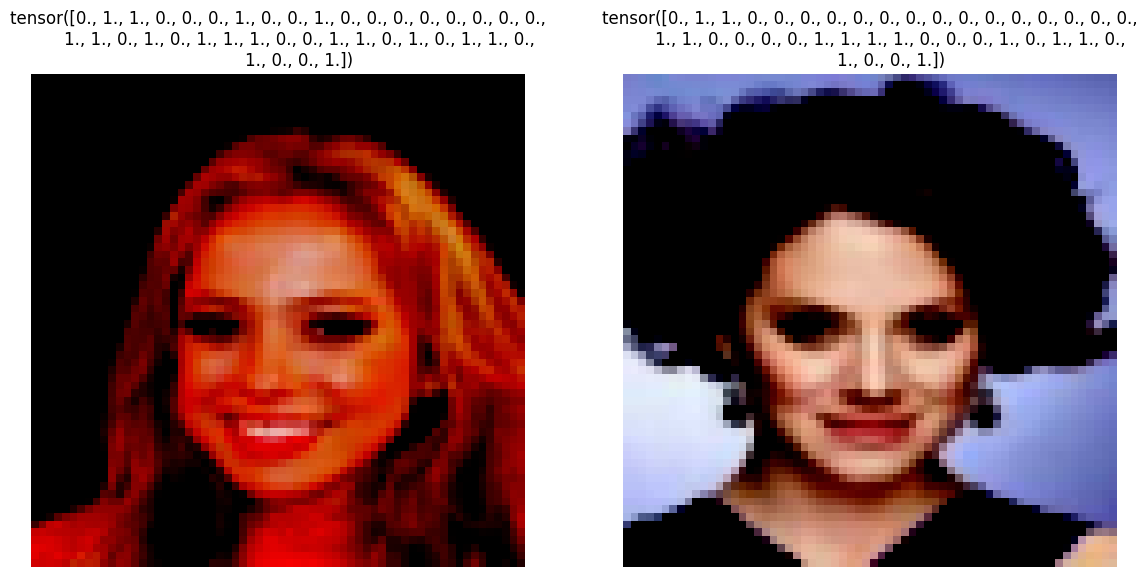

In [ ]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))  # Change to permute to display RGB images correctly
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch import nn
from abc import abstractmethod
from torch.nn import functional as F

Tensor = TypeVar('torch.tensor')

# Conditional VAE Model Archeticture

In [ ]:
class BaseVAE(nn.Module):
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: device, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [ ]:
class ConditionalVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 num_classes: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 img_size:int = 64,
                 **kwargs) -> None:
        super(ConditionalVAE, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.embed_class = nn.Linear(num_classes, img_size * img_size)
        self.embed_data = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        in_channels += 1 # To account for the extra label channel
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim + num_classes, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough to compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        y = kwargs['labels'].float().to(input.device)  # Ensure labels are on the same device
        embedded_class = self.embed_class(y)
        embedded_class = embedded_class.view(-1, self.img_size, self.img_size).unsqueeze(1).to(input.device)
        embedded_input = self.embed_data(input)

        x = torch.cat([embedded_input, embedded_class], dim = 1)
        mu, log_var = self.encode(x)

        z = self.reparameterize(mu, log_var)

        z = torch.cat([z, y], dim = 1)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int,
               **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        y = kwargs['labels'].float().to(current_device)  # Ensure labels are on the correct device
        z = torch.randn(num_samples,
                        self.latent_dim).to(current_device)

        z = torch.cat([z, y], dim=1)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x, **kwargs)[0]

In [ ]:
model = ConditionalVAE(in_channels=3, num_classes=40, latent_dim=128, hidden_dims=[32, 64, 128, 256, 512]).to(device)
model

ConditionalVAE(
  (embed_class): Linear(in_features=40, out_features=4096, bias=True)
  (embed_data): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Ba

In [ ]:
# Function to display images
def show_images(images, num_images=8):
    images = images[:num_images]
    images = images * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    grid_img = torchvision.utils.make_grid(images, nrow=num_images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

# Hyperparameters

In [ ]:
epochs = 30
batch_size = 64
learning_rate = 1e-3 #0.005
latent_dim = 128
num_classes = 40
image_size = 64
KLD_WEIGHT = 0.00025

# Initialize the model and the optimizer

In [ ]:
# Initialize model, optimizer, and loss function
model = ConditionalVAE(in_channels=3, num_classes=num_classes, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

Epoch 1, Loss: 0.059951199781756066


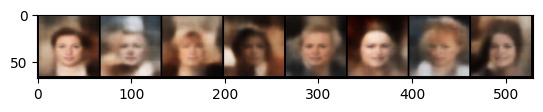

Epoch 2, Loss: 0.0599337560810553


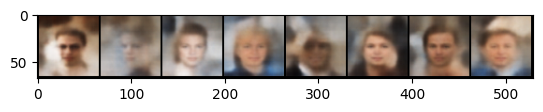

Epoch 3, Loss: 0.06000350064836269


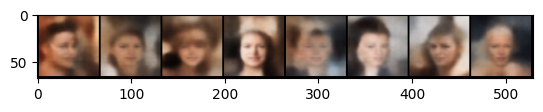

Epoch 4, Loss: 0.05930124116382857


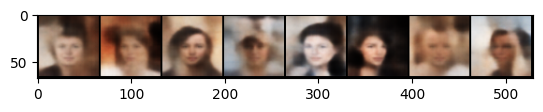

Epoch 5, Loss: 0.05890958092009374


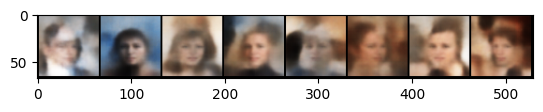

Epoch 6, Loss: 0.05900551497127659


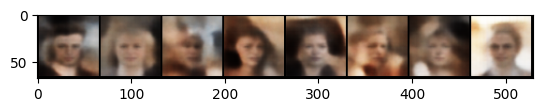

Epoch 7, Loss: 0.05890081353601097


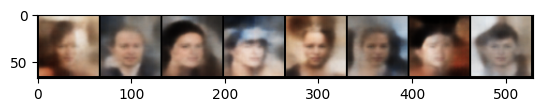

Epoch 8, Loss: 0.05870326006308545


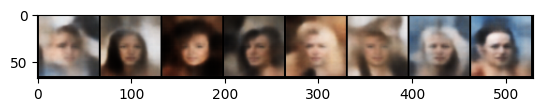

Epoch 9, Loss: 0.05840502830958644


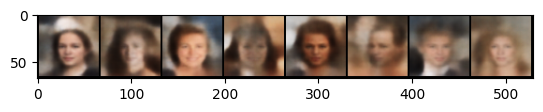

Epoch 10, Loss: 0.058086318129947946


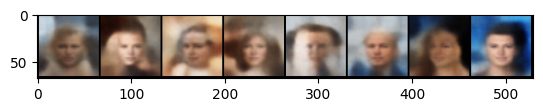

Epoch 11, Loss: 0.0582482742737661


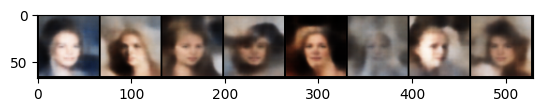

Epoch 12, Loss: 0.057812452157453974


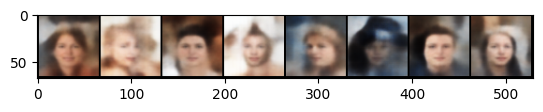

Epoch 13, Loss: 0.05781021875928539


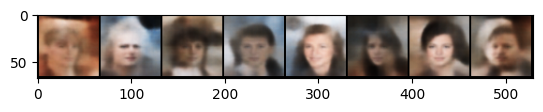

Epoch 14, Loss: 0.05745744853923025


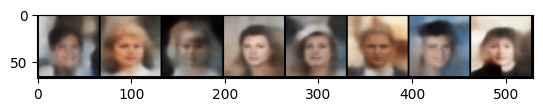

Epoch 15, Loss: 0.05786649788939213


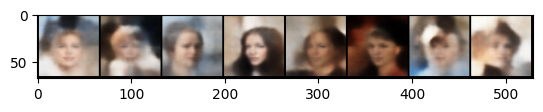

Epoch 16, Loss: 0.057213772304875905


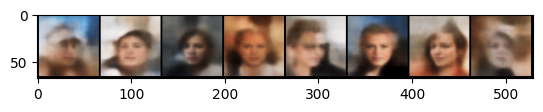

Epoch 17, Loss: 0.05756916149064552


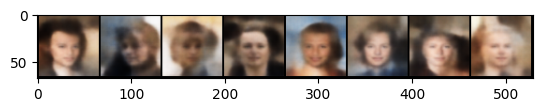

Epoch 18, Loss: 0.05702303401952566


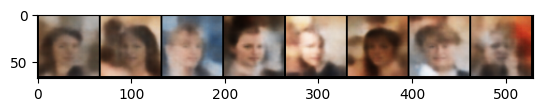

Epoch 19, Loss: 0.05679248043790806


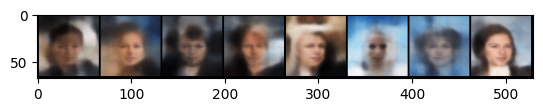

Epoch 20, Loss: 0.056963962553314464


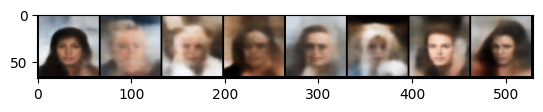

Epoch 21, Loss: 0.056464403997673544


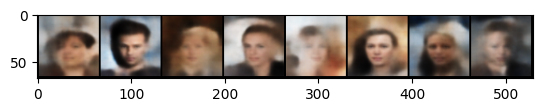

Epoch 22, Loss: 0.05654259557409804


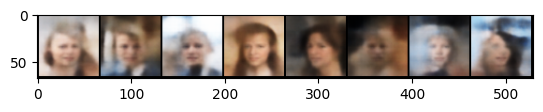

Epoch 23, Loss: 0.05626736301206803


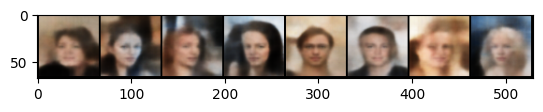

Epoch 24, Loss: 0.05644342659922071


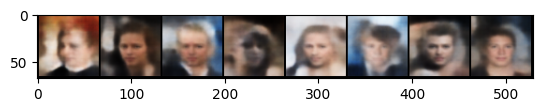

Epoch 25, Loss: 0.05604420930089415


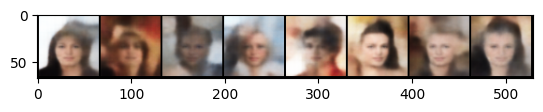

Epoch 26, Loss: 0.0559510901685833


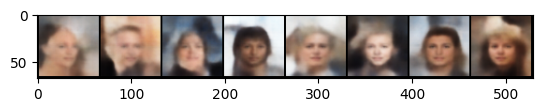

Epoch 27, Loss: 0.0561767248364613


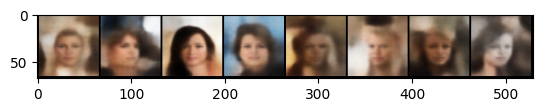

Epoch 28, Loss: 0.055863864734306816


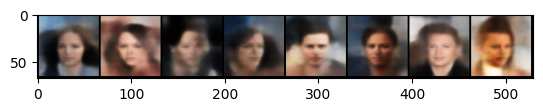

Epoch 29, Loss: 0.055787542589413104


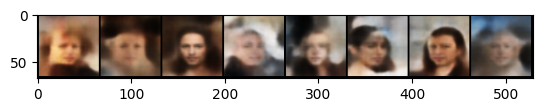

Epoch 30, Loss: 0.05548325601185477


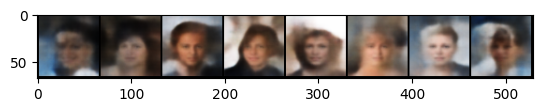

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data, labels=labels)
        recon_images, input_images, mu, log_var = outputs
        loss_dict = model.loss_function(recon_images, input_images, mu, log_var, M_N=KLD_WEIGHT)
        loss = loss_dict['loss']
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(dataloader)}")

    # Generate and display images
    model.eval()
    with torch.no_grad():
        sample_labels = torch.eye(num_classes)[torch.randint(0, num_classes, (batch_size,))].to(device)
        generated_images = model.sample(batch_size, current_device=device, labels=sample_labels)
        show_images(generated_images.cpu())

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'conditional_vae.pth')

# Manipulate the attributes of the images and visualize the results

In [ ]:
# Define a function to manipulate attributes
def manipulate_attributes(num_samples, num_classes, selected_attrs):
    """
    Generate one-hot encoded labels based on the selected attributes.

    Args:
        num_samples (int): Number of samples to generate.
        num_classes (int): Number of attributes.
        selected_attrs (dict): Dictionary where keys are attribute indices (0 to num_classes-1) and
                               values are either 0 or 1 indicating the desired state of the attribute.

    Returns:
        Tensor: One-hot encoded tensor of manipulated attributes.
    """
    labels = torch.zeros((num_samples, num_classes))
    for attr_idx, value in selected_attrs.items():
        labels[:, attr_idx] = value
    return labels

In [ ]:
# List of all attribute names
attribute_names = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
    'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
    'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
    'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
    'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
    'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
    'Wearing_Necktie', 'Young'
]

# Map attribute names to indices
attribute_indices = {name: idx for idx, name in enumerate(attribute_names)}

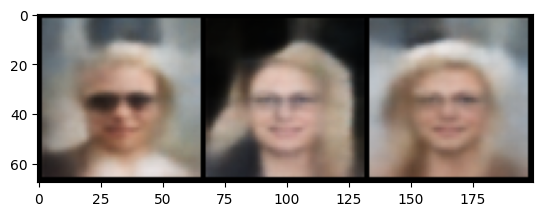

In [ ]:
# Now, let's manipulate attributes and generate images
selected_attrs = {
    attribute_indices['Male']: 0,
    attribute_indices['Eyeglasses']: 1,
    attribute_indices['Blond_Hair']: 1,
    attribute_indices['Smiling']: 1,
    attribute_indices['Bald']: 0,
    # Add more attribute manipulations as needed
}

# Generate one-hot encoded labels for the manipulated attributes
num_samples = 3
manipulated_labels = manipulate_attributes(num_samples, num_classes, selected_attrs).to(device)

# Generate images with the manipulated attributes
model.eval()
with torch.no_grad():
    generated_images = model.sample(num_samples, current_device=device, labels=manipulated_labels)
    show_images(generated_images.cpu())